# Behavioral Cloning - Report

by Gerti Tuzi
March 2017

# Goal: Train Deep NN to learn from human driving to control vehicle
* Collect continuous driving data
* Design and use Keras to implement a Deep Convolutional NN
* Evaluate performance
* Comment on lessons learned


# How to simulate

### Fire up the simulator
This project was developed on Mac OSX, using `mac_sim.app` .

### Control configurations
Two control configurations were developed

#### Opt1: Lateral Control (NN controls steering angle only + steering modulated constant set speed)

From the command line:

```python drive.py model/model_angle.h5```


#### Opt 2: Lateral and Longitudinal Control (NN steering angle + NN set speed)

From the command line:

```python drive_LLCtrl.py model/model_angle.h5 model/model_velocity.h5```

## Visualize Data

#### Load Log File
Location of the images captured were stored in a log file. The parsed log-file become the references to the images, as they in turn, are loaded upon request - to avoid keeping all images in memory.

In [1]:
import csv
loglines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        loglines.append(line)

#### Split Train/Validation/Test

From the whole dataset, 0.3 were kept for testing. The remainder was split into 0.7/0.3 training/validation sets.

In [2]:
from sklearn.model_selection import train_test_split

validation_portion = 0.3

# Log lines are our references to the samples
train_loglines, test_loglines = train_test_split(loglines, test_size=0.333, random_state=0)
train_loglines, validation_loglines = train_test_split(train_loglines, test_size=validation_portion, random_state=0)

num_cams = 3
# 3 cameras * (1 original + 1 horizontal flip)
n_train = len(train_loglines) * num_cams * 2
n_valid = len(validation_loglines)
n_test = len(test_loglines)




### Data generators (`DataGenerators.py`)

I wrote a few data generators to avoid loading images in memory. These generators operate on log file (lines) and pull data onto memory as needed.

*The train generators also implement data augmentations on the fly (random translations and correction injection on labels)*


In [3]:
from DataGenerators import train_generator_3, generator, train_generator_center


train_gen_no_shift_3 = train_generator_3(train_loglines, sixth_of_batch_size=int(6 / 6.),
                                  horizontal_augment=False, do_shuffle = False)

train_gen_shift_3 = train_generator_3(train_loglines, sixth_of_batch_size=int(6 / 6.),
                                  horizontal_augment=True, horizontal_shift_range=0.3, 
                                  vertical_augment = True, vertical_shift_range = 0.1,
                                  rotation_augment = True, rotation_range = 10.,
                                  shear_augment = True, shear_range = 10.,
                                  do_shuffle = False)

train_gen_no_shift_center = train_generator_center(train_loglines, half_batch_size = 1, do_shuffle = False)

test_gen = generator(loglines=test_loglines, batch_size=1)
valid_gen = generator(loglines=validation_loglines, batch_size=1)



## Visualize Images

### Agument angle data by LR flipping 
##### No - Artificial Random Shifts

Data is doubled by flipping in the left-right direction the images and changing the sign of the angle of steering.


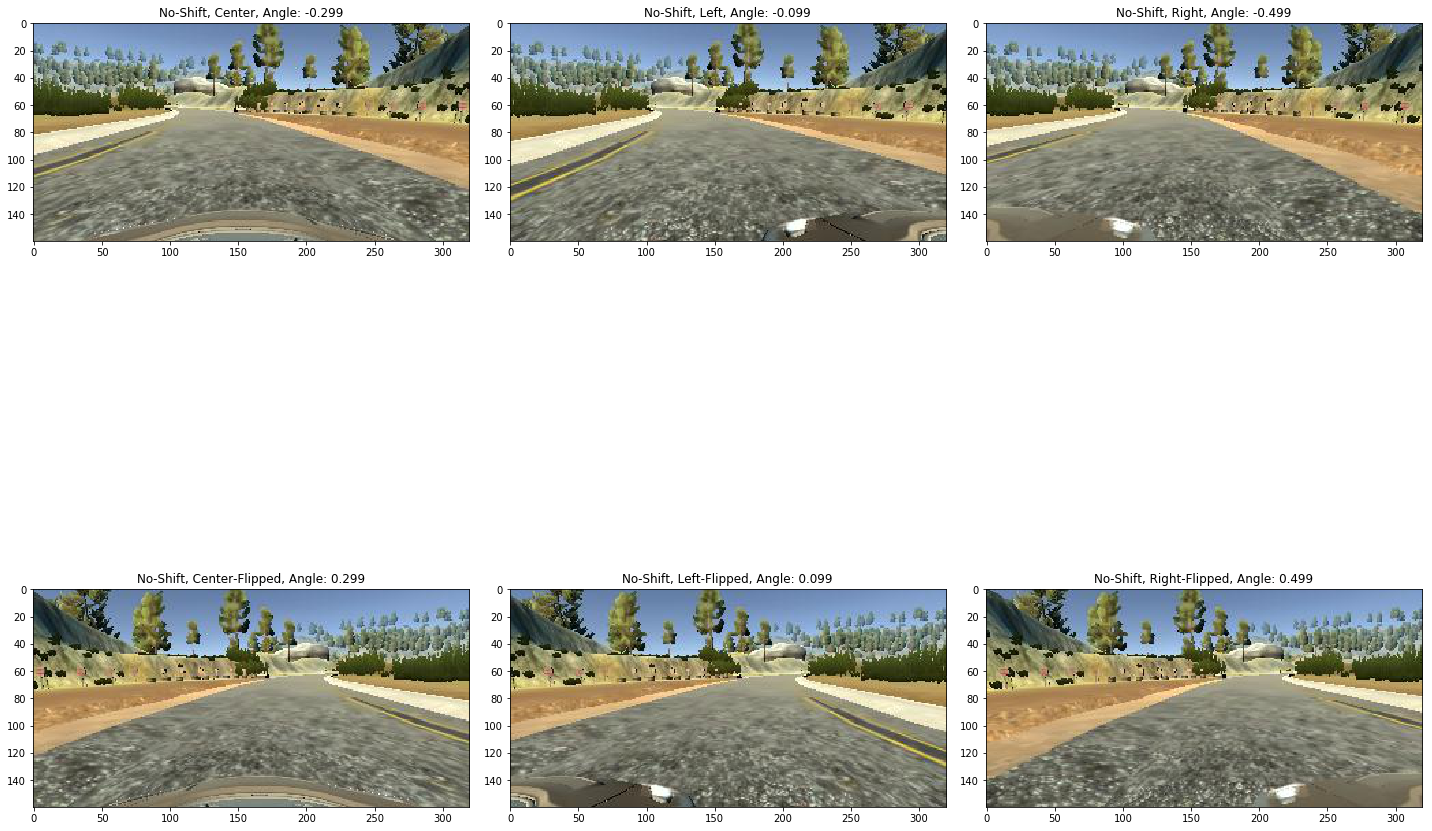

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline  


# No artificial shifts
plt.figure(figsize=(20,20))
title_dict = {0:'Center', 1:'Left', 2:'Right', 
             3:'Center-Flipped', 4:'Left-Flipped', 5:'Right-Flipped'}
for X_batch, y_batch in train_gen_no_shift_3:
    # create a grid of 3x3 images
    for i in range(0, 6):
        plt.subplot(230 + 1 + i)
        plt.title('No-Shift, ' + title_dict[i] + ', Angle: {0:0.3f}'.format(y_batch[i]))
        plt.imshow(X_batch[i].squeeze())        
    # show the plot
    plt.tight_layout()
    plt.show()
    break

## Artificial *horizontal* random shifts 
##### Random steering angle adjustment


Artificial random horizontal shifts are introduced to each image and their respective angle measurement.
* The horizontal shift is applied as a portion *p* of the image width. 
* The same portion is applied to the angular shift as: *new angle = old angle + p x old angle* (see the data augmentation section)

This effectively further augments the data.


Random shear and planar rotation, as well as vertical shifts were also performed


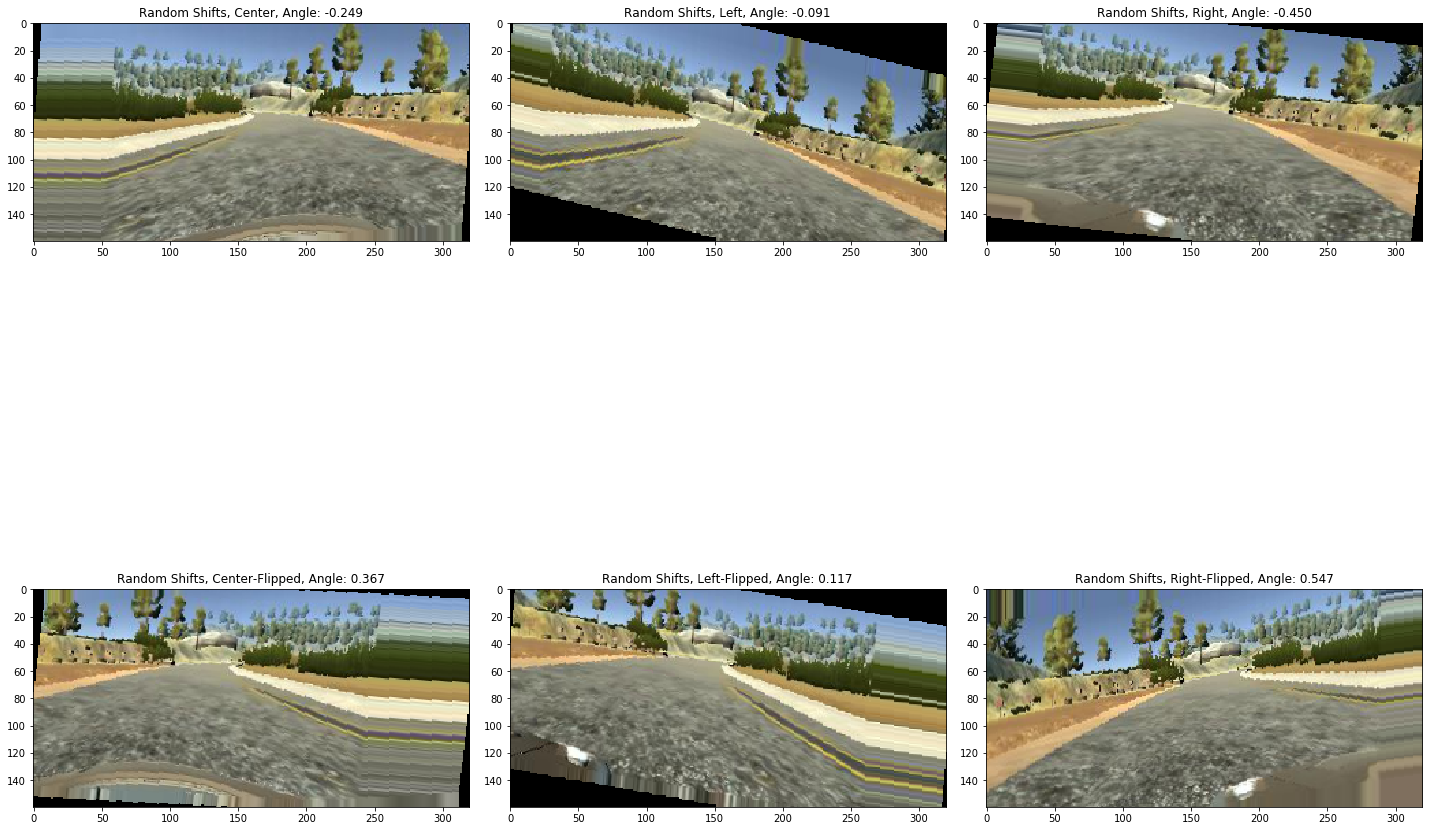

In [5]:
# With artificial shifts
plt.figure(figsize=(20,20))
title_dict = {0:'Center', 1:'Left', 2:'Right', 
             3:'Center-Flipped', 4:'Left-Flipped', 5:'Right-Flipped'}
for X_batch, y_batch in train_gen_shift_3:
    # create a grid of 3x3 images
    for i in range(0, 6):
        plt.subplot(230 + 1 + i)
        plt.title('Random Shifts, ' + title_dict[i] + ', Angle: {0:0.3f}'.format(y_batch[i]))
        plt.imshow(X_batch[i].squeeze())        
    # show the plot
    plt.tight_layout()
    plt.show()
    break

---

# Data collected

Two tracks were presented. 
* Easy: flat surface, wide lanes, longer straight streteches, fewer sharp turns, more wide turns

![EasyTrack](images/easy_track.png)

---

* Hard: mountainous, narrow lanes, few straight stretches, many sharp turns

![HardTrack](images/hard_track.png)

---



## Data Metrics

### Steering angle

**Easy track**: Normal driving on this track yields a very imbalanced label set. This set is heavily dominated by the 0-degree steering angle or center driving - as the track doesn't have many turns. 


It is also costly to generate *recovery* driving - driving which centers the vehicle when veering onto the sides. 



![AngleDistro](images/Easy_track_angle_distro.png)

---

**Hard Track**: hard track has many curves and turns. This track was driven twice in both directions. The following figure shows the steering angle histogram for this track:

![AngleDistro](images/Hard_track_angle_distro.png)


In the hard track, it is obvious to see the effect to the many turns.

---


### Velocity

**Easy track**: the following is the velocity distribution of the easy track

![EasyTrackVelocityDistro](images/Easy_track_velocity_distro.png)

**Hard track**: the following is the velocity distribution of the hard track

![HardTrackVelocityDistro](images/Hard_track_velocity_distro.png)


It is obvious from the velocity histrograms, that the samples collected from the two tracks are sourced from very different distributions.

---

## Data imbalance, agumentations, and knowledge injection

It is very costly to collect an exhaustively representative set of data. Moreover, the easily collected data shows acute imbalances. This imbalance in the dataset is dealt with in the following ways:

#### Emulate lane drifts and correct (augmentation, knowledge injection)
Augment the set using the feed from left / right mounted cameras. Introduce *artificial* corrective steering angle. Pretty much, label the shifted images with a certain offset for the center-keeping steering angle at the time of the data capture. This emulated shift introduces scenarios where the vehicle is veering on one side, and instructs the net (*inject knowledge*) on the corrective action to take. 

Two corrective actions were used: 

(i) steering angle correction of `+/- 0.2` from the current shift (from a left cam shift, `+0.2`, for right cam shift, `-0.2`, where (`+`) sign is counter-clockwise direction). 

Implemented in lines *42-80* in ```DataGenerators.py```


![MultiCam](images/multiple-cameras.png)


(ii) `5mph`  speed slow down, with the assumption, that if a lane drift has been encountered, we would want the vehicle to slow down. *Why 5mph* ?? This seems like a good HMI research topic in the domain of autonomous driving, to answer the question: *What would be an appropriate corrective speed for a given driver preference?*

Implemented in lines *108-150* in ```DataGenerators.py```



---

#### Horizontal random shifts (augmentation, knowledge injection)
During training, random horizontal shifts are applied to imag as a portion `0 < p < 1` of its width, where the applied `p~ = [-p, p]`
Same portion is applied to the steering angular shift as: 

`new angle = actual angle + (p~) x actual angle`

Implemented in lines *67-107* in ```DataAugmentation.py```



#### Capture more under-represented samples
Concentrate on capturing more data for scenarios which are not encountered during driving. Drove multiple times focusing on turns only, keeping the number of trials the same for each scenario.

#### Drive in the oposite direction
Reduces the bias of driving in a particular direction (increases variance in data, helps the NN generalize better)

#### Image LR flip
Introduce opposite driving by flipping the image and switching the sign of the angle of steering. This doesn't effect speed labels.

Implemented in lines *42-80* (angle)  and *108-150* (velocity) in ```DataGenerators.py```

#### Balance scenario specific representation
Maintain an "equally" represented number of samples for corner-driving and center-driving. This was mostly a problem for the heavily imbalanced track (the "easy" track). Balancing was attempted by recording an equal number of drives for each corner, while trying to maintain an equal number of total samples between whole track driving and corner driving. 

#### Leverage bias-variance tradeoff
Favor variance in the bias-variance tradeoff. No Lx-regularization was implemented, very low dropout (0.2) for a relatively large NN. Overfitting (i.e. high variance) was minimized with early termination. Note, that without *any* dropout, validation performance suffered.

#### Sample weighing (not implemented)
Frequency-inverse *weigh* the under-represented samples.

#### Collect more under-represented data
Expensive and perhaps unavoidable



# Convolutional Network 

### Image pre-processing

Images were cropped 50 pixels from the top, and 20 pixels from the bottom, to remove information that doesn't carry any road information (and also speeds up processing). Moreover, images were mean normalized before being fed into the net.


Image pre-processing was implemented at the input of the NN, in lines *44-50* in ``` GTRegressionModel.py ```

## Architecture 
**GTRegression** (```GTRegressionModel.py ```, lines: *55 - 110*)

![GTRegression](images/GTRegression.png)

* Initially a quick drop of image size was desired.
* However, according to [[1]](https://pdfs.semanticscholar.org/1d6e/6adc7a841393fc10b78dc0018e550aff589d.pdf), in the earlier layers of the networks, local features are closely correlated. To capture the close correlation, *while* reducing the size as quick as possible, a "large" kernel size (5x5 for the first conv layer) was used, but with a stride of 2 so that local correlation information is retained as much as possible.
* The intermediary layers were selected such that there was a continuous drop in spatial size and an increase in network depth.
* Used spatial dropouts to promote robustness into the extracted feature maps (as opposed to regular random dropout which would yield a reduced learning rate [[link]](https://arxiv.org/pdf/1411.4280.pdf). Spatial dropout causes entire feature maps to be randomly dropped during training, thus forcing other feature maps to be more robust.
* *Global average pooling* was used before the fully connected layers. Dropout effectively creates multiple network configurations by varying the activated feature maps during spatial dropouts. Also, the deep layers of the neural networks effectively capture high level abstractions (factors) of the underlying data generating distributions. Therefore, using dropout as a model of creating multiple deep nets, average pooling takes the votes of those nets which specialized in learning more about particular abstractions, as represented by individual feature maps of the last conv layer output. Moreover, if we assume that such underlying factors have been able to fully linearize (disentangle) the latent factors, we can piece-wise approximate the left over non-linearities by a linear combination of these latent representations. No harm would be done if these latent variables *have* indeed been able to fully linearize latent representations as they are lineraly re-combined (however at the cost of having another fully connected layer, i.e. computational cost). 
* For the longitudinal controller - see below - a relu layer should be used to avoid negative speeds. Even though, this should not happen, as the training set of speeds has only non-negative values*
* Fully connected layer (128) was used to approximate any non-linearities that were not captured from the earlier layers.
* Fully connected layer (1) which is the measure output (logit).


The Keras implementation of *GTRegression* is found in the `GTRegression.py` module.

---

### Longitudinal and Latitudinal Convolutional Network Models

GTRegression architecture was used for two deep neural nets with the following control functions:

* **Latitudinal** convolutional network: controls the steering angle of the vehicle.
![LongController](images/Lat_Controller.png)

* **Longitudinal** convolutional network: controls the speed of the vehicle. It outputs the set-speed that goes into the PI controller (which in turn, generates the throttle command required by the vehicle model). A cap of minimum 5 mph was placed to ensure not stalling.
![LatController](images/Long_Controller.png)


Initially, trials were done using only latitudinal controller, with a fixed target speed. Next, longitudinal controller was trained and used alongside the latitudinal controller.


---

## Control Configuration and Implementation


Two configurations were used:

* Lateral controller with steering-modulated speed

![LatControlConfig](images/Lat_Control_Config.png)


This controller modulates a pre-fixed constant speed according to the amount by which the vehicle is turning. The assumption here is that, in the extreme, if the vehicle turns hard, we would like to slow down enough to take the turn. Several values for `alpha` were tried. It seems that the value of `0.2` performs satisfactorily (prevents skidding and doesn't stall the vehicle)

Implementation: ```drive.py ```, lines *66-70*.

---

* Lateral and Longitudinal controller where each deep network controls steering and vehicle set speed.

![LatLongControlConfig](images/Lat_Long_Config.png)

The speed output of the longitudinal network is clipped in the range `[5mph, 20 mph]`. A speed below `5mph` would stall the vehicle in the simulator. A speed above `20mph` causes severe center-seeking driving behavior in straight segments. 

Implementation: `drive_LLCtrl.py`, lines *66-72*

---

## Training (`BasicRegressionModelTraining.ipynb`)

The training harness `BasicRegressionModelTraining.ipynb`, allows two modes for training:
* angle
* velocity

### Latitudinal controller (steering angle)

As mentioned in the data description section, data is highly imbalanced (for steering angle). So the model should be able to capture (the distribution of) the low-frequency events (high angle turns) while not introducing artifacts during the most frequent, center driving, or 0-degree events (for example, a bouncing left-right driving pattern). This is achieved by creating a high-variance model with artificial corrective behavior injected in the training data.

* A model with high enough variance is desired, in order to capture/model infrequent events. In order to achieve this, no Lx regularizations were used. Initial trials using these regularization methods, yielded highly biased models which always output a value of approx. 0-degrees steering. 
* To maintain a stable center-lane driving with a high-variance model: Label the shifted images of Left/Right camera feeds, which emulate lane drifts, with artificial steering offsets. This *injects* stability during center-lane driving, when using only the center camera (online).
* To prevent overfitting in this case, early termination was implemented and the model with the highest validation score was kept (refer to *label imbalance* section above)
* Validation was performed on the set of center-camera images and true steering angle labels


### Longitudinal controller (speed)

For training the longitudinal controller (speed control), the augmented data was labeled with artificial "slowing-down" influcences. That is, on the shifted images (left/right cams), *5mph* were reduced from the speed label of that sample.

Like for the latitudinal controller, random data augmentations (horizontal/vertical shifts, rotations, etc) were also used, as well as the strategies for reducing overfitting by early training termination.


### Training parameters

* Maximum number of Epochs less than 50.
* The model with best validation MSE was used
* Batch size: 90
* Dropout rate: 0.2
* Adam optimizer for fast convergance.

Data splits:
* Training / testing proportions : 0.7/0.3
* Then out of training above, training / validation: 0.7 / 0.3

Yielding the following sample counts:

* Train Samples: 72912
* Valid Samples: 5208
* Test Samples: 8668

### Training history


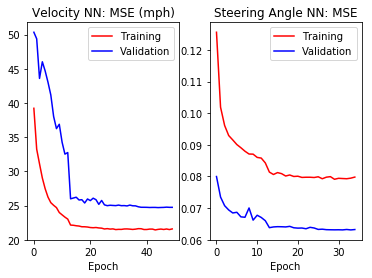

In [75]:
import pickle
with open('velocity_train_history.pickle', 'rb') as vel_handle, open('angle_train_history.pickle', 'rb') as angle_handle:
    vel_hist = pickle.load(vel_handle)
    angle_hist = pickle.load(angle_handle)
    
    plt.subplot(121)
    plt.plot(vel_hist['loss'], 'r-', vel_hist['val_loss'], 'b-')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.title('Velocity NN: MSE (mph)')
    
    
    plt.subplot(122)
    plt.plot(angle_hist['loss'], 'r-', angle_hist['val_loss'], 'b-')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    plt.title('Steering Angle NN: MSE')
    

* Training MSE is measured on augmented data (shifted cameras, random rotations, flipped images, random shifts)
* Validation MSE is measured on original *center-camera* images and original labels.

* *Velocity NN controller training*: graph reflects what we would expect, that is, training error is always smaller than validation error. Overfitting has been avoided by only keeping the model with the smallest validation error. The lack of improvement of validation past 50 epochs was used as criterion for early termination of training.

* *Steering angle NN controller training* **unusual behavior**. Validation MSE is smaller than training MSE. *The following is a conjecture which needs to be verified and shown*: During training, the *labelset* is augmented randomly by the proportional adjustment of the horizontal image shift. This effectively introduces a new generative distribution during traing. This new distribution is a superset of the original distribution, and which the validation set follows. The distribution during training would have thicker tail-ends than the validation distribution. Again, this needs to be demonstrated. However, for velocity NN training, this random augmentation of the labelset is not occurring, thus the training metrics follow what is expected.

In [6]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Simulations

## Lateral control with steering modulated speed

Models shown here were trained on both tracks so that they generalize better.

Both drivings display small centre-lane-seeking behavior, due to the fairly slow speed.


### Simulation on *simple* track

In [80]:
vid = 'simu_vids_lat_ctrl/BothTrack_Trained/EasyTrack/simu_images.mp4'

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(vid))

### Simulation on *hard* track

In [77]:
vid = 'simu_vids_lat_ctrl/BothTrack_Trained/HardTrack/simu_images.mp4'

HTML("""
<video width="320" height="160" controls>
  <source src="{0}">
</video>
""".format(vid))

## Lateral & Longitudinal control 

Longitudinal controller emulates driver's pattern of speed. Lateral control (steering angle) here is the same NN as the one used for lateral control only.


### Simulation on *easy* track

In the easy track I drove at maximum speed most of the time. **The artificial corrections introduced in the drifts are fixed and too large for high speeds.** This is reflected in the center searching behavior of the vehicle in this track. The large correction tends to overshoot the vehicle over the center - due to the high speed - and the opposite correction causes the reverse.

In [78]:
vid = 'simu_vids_lat_long_ctrl/Easy_Track/simu_drive_cam.mp4'

HTML("""
<video width="280" height="220" controls>
  <source src="{0}">
</video>
""".format(vid))

### Simulation on *hard* track

In the hard track I drove at fairly low speeds. The corrective behavior has lower magnitude here, as the longitudinal controller does not request very high speeds.


In [79]:
vid = 'simu_vids_lat_long_ctrl/Hard_Track/simu_drive_cam.mp4'

HTML("""
<video width="280" height="220" controls>
  <source src="{0}">
</video>
""".format(vid))

# Observations & Comments

#### Training / testing only on specific track vs. training cross track
When training and testing on the same track, the model displays smaller center-lane-seeking behavior (i.e. fewer fluctuations). Cross track seems to have a more pronounced center - seeking behavior.

#### How was behavior when training using single center camera vs. the left/right ones
Using a single camera it was noticed that the vehicle failed more often at sharp turns, and tight lanes (when a rock would portrude slightly over into the lane). This shows the lack of perspective that is missing using only the middle camera.

#### What other inputs can be added to the network to perform better ?
Adding vehicle speed, accelerometer parameters, past&present dynamic history should make performance much more robust. Also, using such inputs, more artificial methods can be implemented. ** It is necessary to modulate the articial correction for speed/acceleration**. Also, the need for either for more natural recovery data collection, broader array of shifted cameras, geometrically optimized corrections per shifted camera and a mixture of the above approaches.


#### Lane switching
In the hard track, whe the car ends up switching the lane, it starts recognizing the new lane as the lane to keep. Lane recovery behavior or data needs to be added to training to avoid wrong-lane driving





# Keras / TensorFlow

* Keras version 2.0.1 and TensorFlow 0.12 . 
* Some issues were encountered: concat layer fails. Version of Keras 2.x should work better with TF 1.x

